In [3]:
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scvi

In [15]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

#### Integrating data from three Donor samples 


In [4]:
[file for file in os.listdir() if "filtered_feature_bc_matrix.h5" in file]

['Donor1_filtered_feature_bc_matrix.h5',
 'Donor2_filtered_feature_bc_matrix.h5',
 'Donor3_filtered_feature_bc_matrix.h5']

In [ ]:
def preprocessing(h5file):
    
    adata = sc.read_10x_h5(h5file)
    adata.var_names_make_unique()
    adata.var.index = adata.var_names
    # no doublet removal if you want we can do that here
    adata.obs['Sample'] = h5file[:6]
    adata.var['mt'] = adata.var_names.str.startswith('mt-') 
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

    sc.pp.filter_genes(adata, min_cells = 3)
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_cells(adata, min_counts=500)

    upper_genes = np.quantile(adata.obs.n_genes_by_counts.values, .99)
    adata = adata[adata.obs.n_genes_by_counts < upper_genes]
    upper_counts = np.quantile(adata.obs.total_counts.values, .99)
    adata = adata[adata.obs.total_counts < upper_counts]

    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 20]
   
    
    return adata
    

In [6]:
outs = []

files = [f for f in os.listdir() if "filtered_feature_bc_matrix.h5" in f]
print(files)

for file in files:
    outs.append(preprocessing(file))

['Donor1_filtered_feature_bc_matrix.h5', 'Donor2_filtered_feature_bc_matrix.h5', 'Donor3_filtered_feature_bc_matrix.h5']


c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1793: UserWarning: Variable names are not unique. To make them u

In [7]:
outs

[View of AnnData object with n_obs × n_vars = 7799 × 21851
     obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells',
 View of AnnData object with n_obs × n_vars = 11298 × 23214
     obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells',
 View of AnnData object with n_obs × n_vars = 7035 × 25272
     obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 

In [8]:
adata = sc.concat(outs)

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\anndata\_core\anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


#### Normalize

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#### Feature selection

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

#### Dimensionality reduction & Clustering

#### PCA

c:\Users\19utk\anaconda3\envs\ds\Lib\site-packages\scanpy\preprocessing\_pca\__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


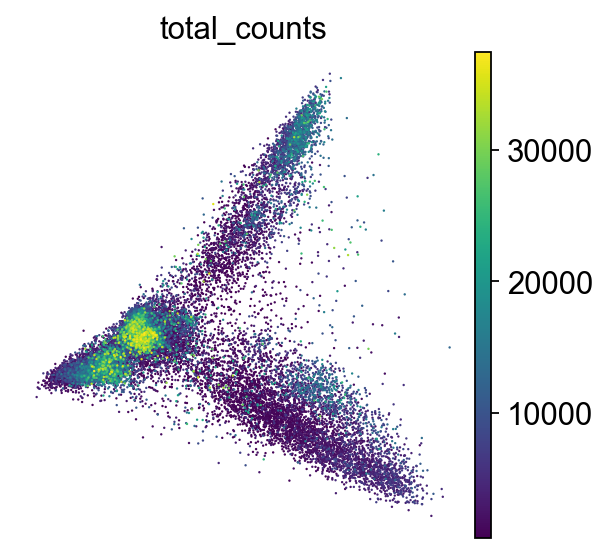

In [16]:
sc.pp.pca(adata, use_highly_variable=True)
sc.pl.pca_scatter(adata, color="total_counts")

#### t-SNE

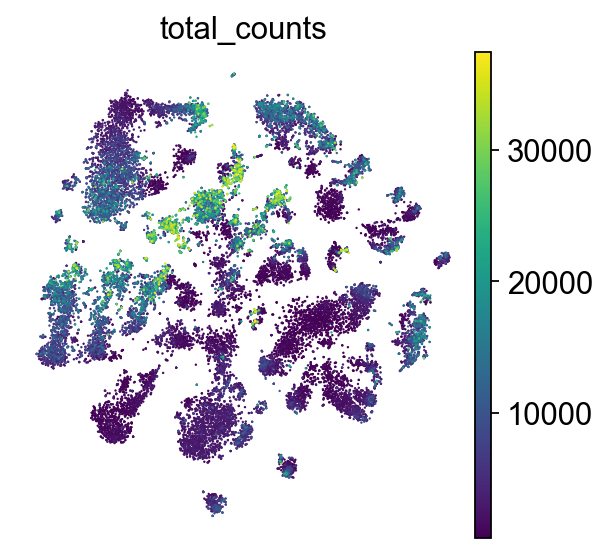

In [ ]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color="total_counts")

#### UMAP

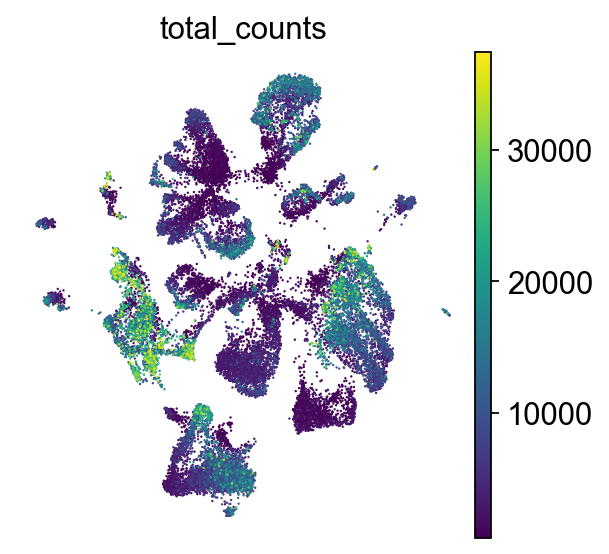

In [21]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="total_counts")

#### Clustering

In [ ]:
# default resolution is 1
# sc.tl.leiden(adata)

C:\Users\19utk\AppData\Local\Temp\ipykernel_51604\3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [24]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

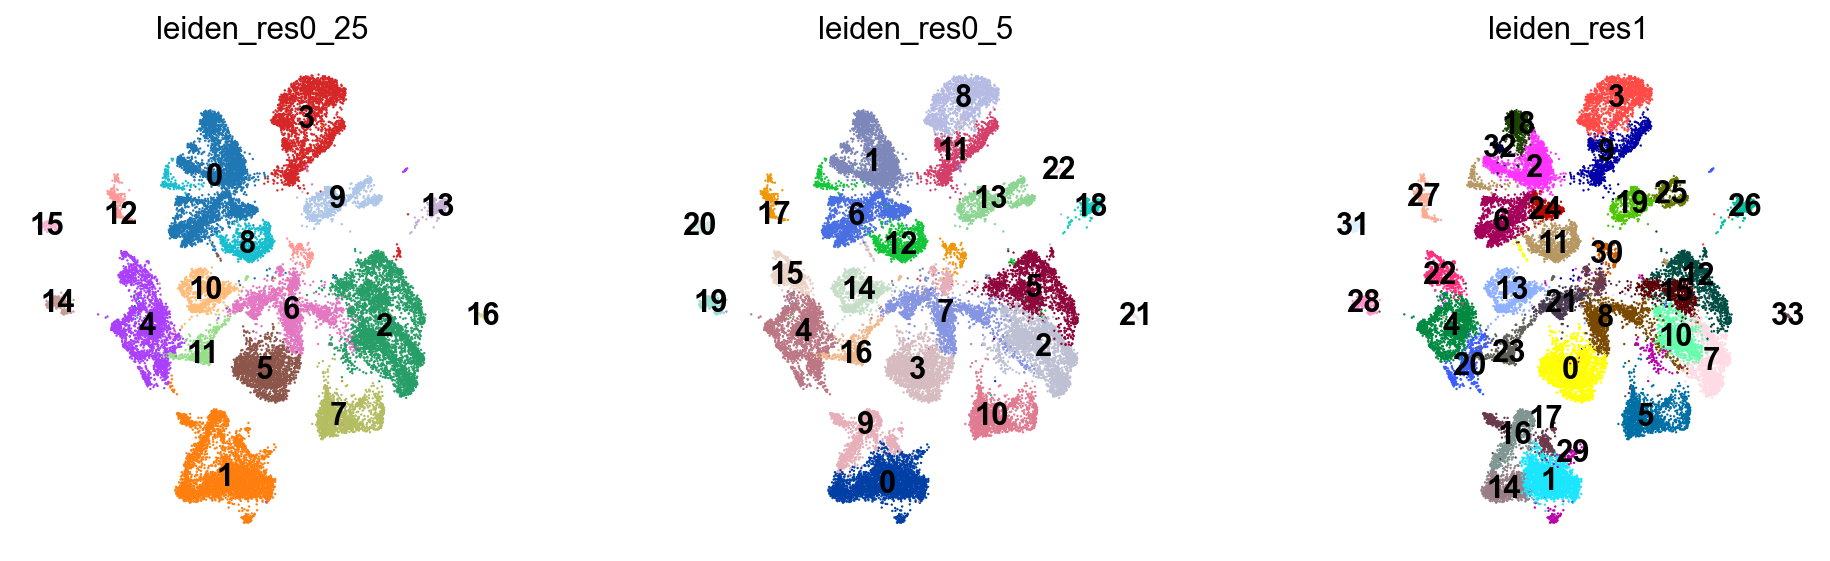

In [25]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [26]:
sc.tl.leiden(adata, resolution=0.25)

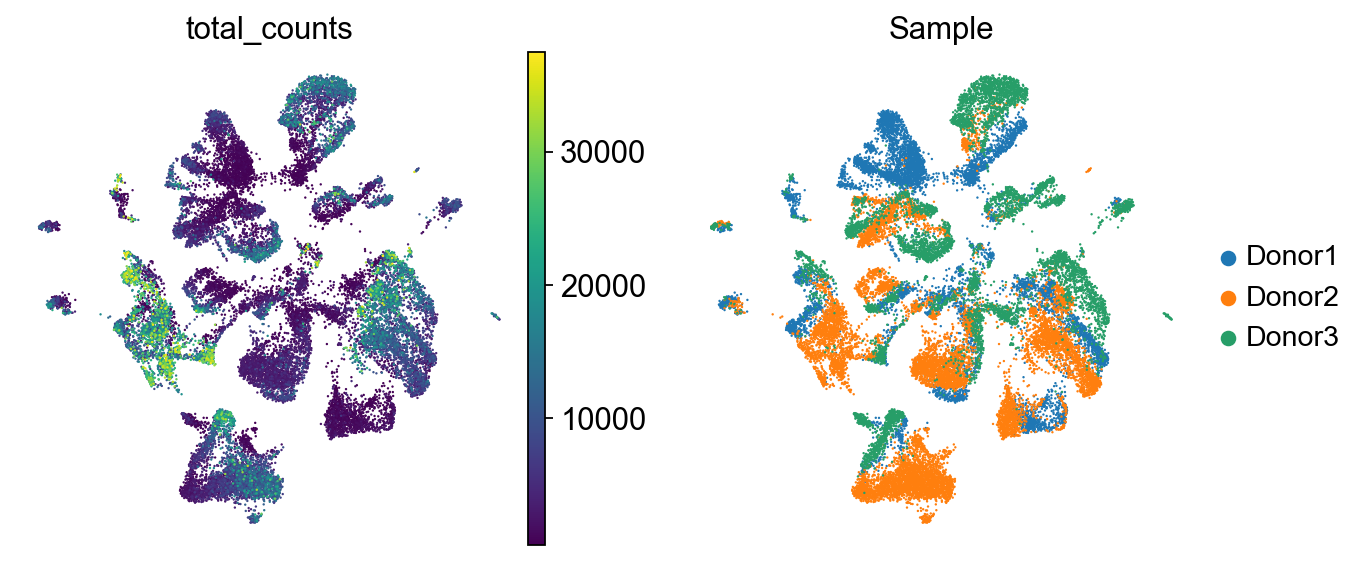

In [ ]:
# no donor specific clusters

sc.pl.umap(
    adata,
    color=["total_counts", "Sample"],
)